In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def sample_spherical(N, k): # 구형태 spherical distribution
    vec = np.random.randn(k, N)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def sample_elliptical(N, d, k, mu):
    S = sample_spherical(N, k)
    A = np.random.rand(d,k)
    R = np.random.normal(size=N)
    return mu + A.dot(R*S) # elliptical distribution 으로 변형

def SMInv(Ainv, u, v): 
    return Ainv - np.dot(Ainv, np.dot(np.outer(u,v), Ainv)) / ( 1 + np.dot(v, np.dot(Ainv, u)))


def random_ball(num_points, dimension, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T, 

In [2]:
# ETC alogrithm 

class ETC:
    def __init__(self):
        self.expected_optimal = [] #초기화

    def exploration(self,t,N):
        #choose action t mod N 
        action_choose = t%N
        return action_choose

    def exploitation(self,t,reward_observe):
        estimate = np.mean(reward_observe,axis=0)
        self.expected_optimal = np.argmax(estimate) #mu가 최대인 arm 저장
        return self.expected_optimal
#환경
def env(action_choose, true_reward, error): 
    reward = true_reward[action_choose] + error
    return reward

In [17]:
class UCB:
    def __init__(self,T,N):
        self.reward_store = np.zeros((T,N)) #reward

    def exploration(self,t):
        action_chooose = t
        return action_chooose

    def find_action(self,N,alpha):
        selected_number = np.count_nonzero(self.reward_store,axis=0)
        # bound = np.mean(self.reward_store,axis=0)+np.sqrt(alpha*(1/selected_number))
        bound = np.sum(self.reward_store,axis=0)/selected_number+np.sqrt(alpha*(1/selected_number))
        
        action_choose = np.argmax(bound)

        return action_choose
    
    def update(self,t,reward_observe,action_choose):

        self.reward_store[t,action_choose]=reward_observe
    
def env(action_choose, true_reward, error):
    reward = true_reward[action_choose]+error
    return reward


In [ ]:
class Greedy:
    def __init__(self,T,N):
        self.reward_store = np.zeros(N)+0.5
    def exploitation(self,T,N)
        

In [12]:
def simulation_ETC(N,T,m,true_reward,R):
    etc=ETC()
    Regret = np.zeros((T,1)) #regret을 0으로 Tx1으로 초기화
    reward_observe = np.zeros((m,N))
    optimal = np.argmax(true_reward)
    for t in range(T):
        if t<m*N: #처음에 당기기
            action_choose = etc.exploration(t,N)
            error = np.random.normal(0,R)
            reward_observe[t//N,t%N] = env(action_choose,true_reward,error)
        
        #if we didn't choose optimal action yet
        elif not etc.expected_optimal:
            action_choose = etc.exploitation(t,reward_observe)
        #exploit optimal action 
        else:
            action_choose = etc.expected_optimal
        regret = true_reward[optimal]-true_reward[action_choose]

        if t==0:
            Regret[t] = regret #소문자: t시점의 regret, 대문자: 누적 regret 
        else:
            Regret[t] = Regret[t-1]+regret
    return Regret


In [13]:
def simulation_UCB(N,T,true_reward,R):
    Regret = np.zeros((T,1)) #누적 regret 저장
    optimal = np.argmax(true_reward)
    delta = 0.05
    alpha=2*R**2*np.log(1/delta) #use for upper confidence bound
    ucb = UCB(T,N)

    for t in range(T):
        if t<N: #처음에는 한번씩 당겨라
            action_choose = ucb.exploration(t)
        else:
            action_choose = ucb.find_action(N,alpha)
        
        #observe reward
        error = np.random.normal(0,R)
        reward_observe = env(action_choose, true_reward, error)

        ucb.update(t, reward_observe,action_choose)
        regret = true_reward[optimal]-true_reward[action_choose]

        if t ==0:
            Regret[t]=regret
        else:
            Regret[t]=Regret[t-1]+regret
    return Regret

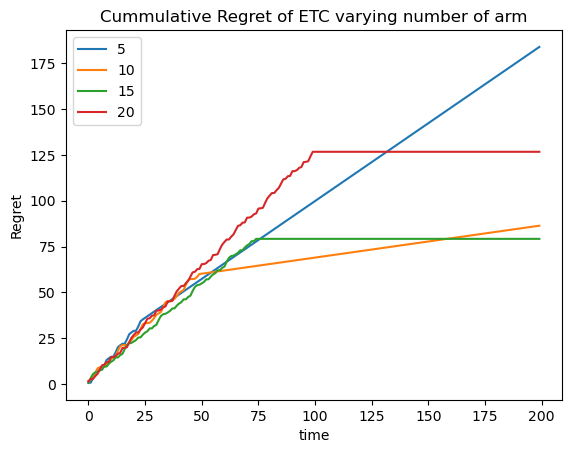

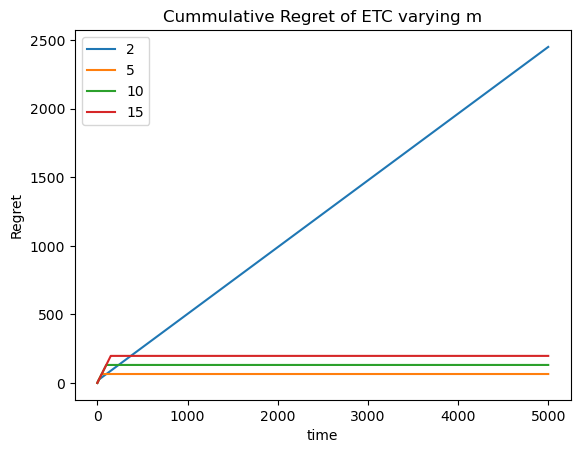

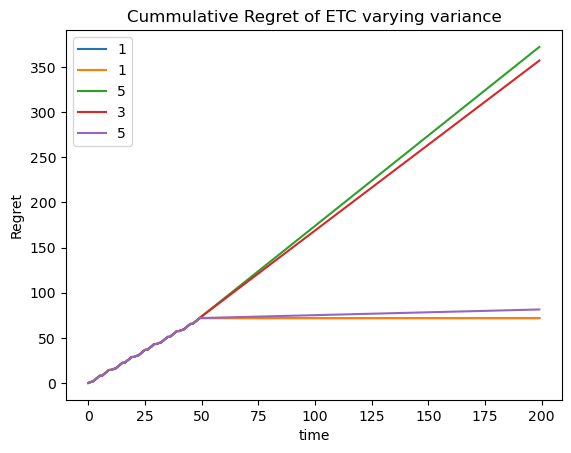

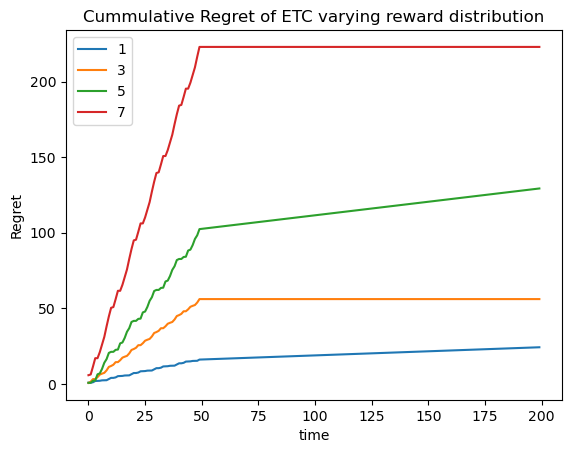

In [35]:
#실험1. arm당 변화
T=200 #200번 당기기
m=5 #한 arm당 몇번 당길것인지
R=1 #1-sub gaussian error
number_of_arm = [5,10,15,20] # arm의 개수
for N in (number_of_arm):
    true_reward = np.random.rand(N,1)*3 #0~3사이의 균등분포
    Regret = simulation_ETC(N,T,m,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(number_of_arm)
plt.title('Cummulative Regret of ETC varying number of arm')
# plt.title('Cummulative Regret of UCB varying number of arm')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()


#실험2. m에 따른 변화
T=5000
R=1
N=10
true_reward = np.random.rand(N,1)*3
selecting_times = [2,5,10,15]
for m in (selecting_times):
    Regret = simulation_ETC(N,T,m,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(selecting_times)
plt.title('Cummulative Regret of ETC varying m')
# plt.title('Cummulative Regret of UCB varying m')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()


#실험3. true reward distribution의 분산의 변화
T=200
N=10
m=5
true_reward = np.random.rand(N,1)*3
varing_set = [1,1,5,3,5]
for R in (varing_set):
    Regret = simulation_ETC(N,T,m,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(varing_set)
plt.title('Cummulative Regret of ETC varying variance')
# plt.title('Cummulative Regret of UCB varying variance')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()


#실험4. delta가 커질때
T=200
N=10
m=5
R=1
varing_set = [1,3,5,7]
for i in (varing_set):
    true_reward = np.random.rand(N,1)*i
    Regret = simulation_ETC(N,T,m,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(varing_set)
plt.title('Cummulative Regret of ETC varying reward distribution')
# plt.title('Cummulative Regret of UCB varying reward distribution')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()

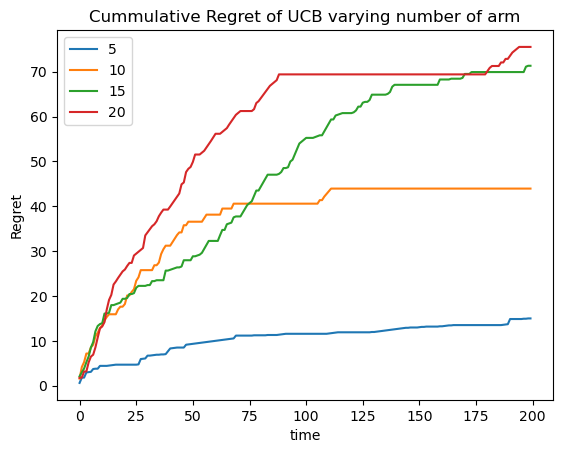

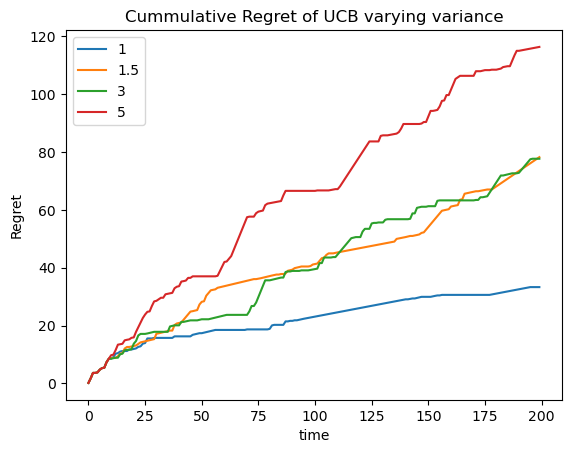

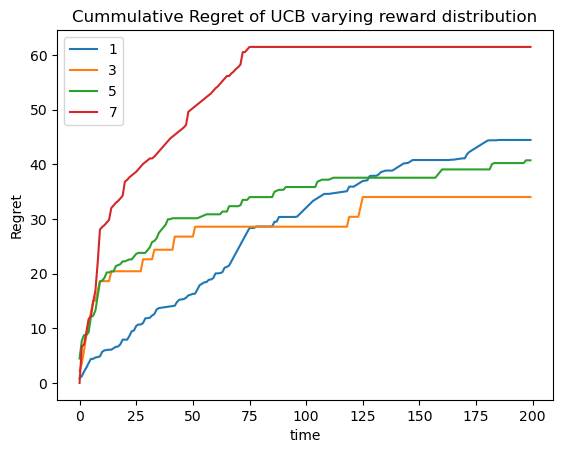

In [40]:
T=200
R=1
varing_set = [5,10,15,20]
for N in (varing_set):
    true_reward = np.random.rand(N,1)*3
    # Regret = simulation_ETC(N,T,m,true_reward,R)
    Regret = simulation_UCB(N,T,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(varing_set)
# plt.title('Cummulative Regret of ETC varying number of arm')
plt.title('Cummulative Regret of UCB varying number of arm')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()



T=200
N=10
true_reward = np.random.rand(N,1)*3
varing_set = [1,1.5,3,5]
for R in (varing_set):
    # Regret = simulation_ETC(N,T,m,true_reward,R)
    Regret = simulation_UCB(N,T,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(varing_set)
# plt.title('Cummulative Regret of ETC varying variance')
plt.title('Cummulative Regret of UCB varying variance')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()



T=200
N=10
R=1
varing_set = [1,3,5,7]
for i in (varing_set):
    true_reward = np.random.rand(N,1)*i
    # Regret = simulation_ETC(N,T,m,true_reward,R)
    Regret = simulation_UCB(N,T,true_reward,R)

    time = np.linspace(0,T-1,T)
    plt.plot(time,Regret)
plt.legend(varing_set)
# plt.title('Cummulative Regret of ETC varying reward distribution')
plt.title('Cummulative Regret of UCB varying reward distribution')
plt.xlabel('time')
plt.ylabel('Regret')
plt.show()